
Python code for the Exercise 4.6 in "Simo Sarkka,
Bayesian Filtering and Smoothing". <br>
The exercise consists in completing the functions:
- `kf_update`
- `steady_kf_update`

Both methods will have the signature:

```python

def update_method(x, cov, obs): 
    """ Update the state belief based on prior belief and new observation
    """
    
    return updated_x, updated_cov

```

## Standard imports

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as st

np.random.seed(31415926)

ModuleNotFoundError: No module named 'matplotlib'

## Utility functions

In [2]:
def mv_normal(m, C):
    """ Samples a multivariate normal of mean m and covariance C
    
    """
    sample = np.random.randn(*m.shape)
    return m + np.linalg.cholesky(C) @ sample

In [3]:
def rmse(x, y):
    """ Root mean square error between two vectors x and y
    
    """
    return np.sqrt(np.mean(np.square(x-y)))

In [4]:
def filter_routine(initial_guess, initial_guess_covariance, update_method, observations):
    """ Loops over the observations and calls the implemented update_method
   
    """
    T = observations.shape[0]
    x = initial_guess[:]
    cov = initial_guess_covariance[:]
    
    states = np.empty((T, *x.shape))
    covariances = np.empty((T, *initial_guess_covariance.shape))
    
    for i, y in enumerate(observations):
        x, cov = update_method(x, cov, y)
        states[i, :] = x
        covariances[i, :] = cov
    
    return states, covariances
    

In [5]:
def plot_results(filtered_states, true_states, observations, title, filtered_covariances=None):
    fig, axes = plt.subplots(nrows=2, figsize=(12, 10), sharex=True)
    
    T = observations.shape[0]
    
    axes[0].plot(filtered_states[:, 0], label="Estimated signal", color="b")
    axes[0].plot(true_states[:, 0], label="True signal", linestyle='--', color="r")
    axes[0].scatter(np.arange(T), observations, marker="o", color="g", label="Measurements")    
    
    axes[1].plot(filtered_states[:, 1], label="Estimated derivative", color="b")
    axes[1].plot(true_states[:, 1], label="True derivative", linestyle='--', color="r")
    
    error = rmse(filtered_states, true_states)
    
    for ax in axes.flatten():
        ax.legend(loc="upper left")
    
    if filtered_covariances is not None:
        axes[0].fill_between(np.arange(T), 
                             filtered_states[:, 0] - filtered_covariances[:, 0, 0],
                             filtered_states[:, 0] + filtered_covariances[:, 0, 0],
                             alpha=0.33, 
                             color="b")
        axes[1].fill_between(np.arange(T), 
                             filtered_states[:, 1] - filtered_covariances[:, 1, 1],
                             filtered_states[:, 1] + filtered_covariances[:, 1, 1],
                             alpha=0.33, 
                             color="b")
        fig.suptitle(f"{title} and confidence intervals - RMSE: {error:.3f}")
    else:
        fig.suptitle(f"{title} - RMSE = {error:.3f}")


## Get data

For the remainder of the notebook, we will take: 
- $\omega = 0.5$
- $q = 0.01$
- $r = 0.1$

In [6]:
w = 0.5
q = 0.01
r = 0.1

T = 100
x_0 = np.array([0, 0.1])

In [7]:
def get_data(w, q, r, x_0, T):
    """ Generates data according to the state space model above
    
    """
    Q = 0.5 * q * np.array([[(w - np.cos(w) * np.sin(w)) / w ** 3, np.sin(w) ** 2 / w ** 2],
                            [np.sin(w) ** 2 / w ** 2, (w + np.cos(w) * np.sin(w)) / w]])
    
    A = np.array([[np.cos(w), np.sin(w) / w], 
                  [-w * np.sin(w), np.cos(w)]])
    
    C = np.array([1, 0])
    
    observations = np.empty(T)
    true_states = np.empty((T, 2))
    
    x = x_0[:]
    true_states[0] = x
    
    for i in range(T):
        observations[i] = C.dot(x) + np.sqrt(r) * np.random.randn()
        x = mv_normal(np.matmul(A, x), Q)
        if i == T-1:
            break
        true_states[i+1, :] = x
        
    return observations, true_states, Q, A, C


In [8]:
observations, true_states, Q, A, C = get_data(w, q, r, x_0, T)

In [9]:
def plot_state(observations, true_states, T):
    fig, ax = plt.subplots(figsize=(12, 5))
    ax.plot(true_states[:, 0], linestyle='--', label="True Signal")
    ax.scatter(np.arange(T), observations, marker='o', label="Measurements")
    ax.set_xlabel("Time step")
    ax.legend(loc="upper left")
    fig.suptitle("Simulated data")

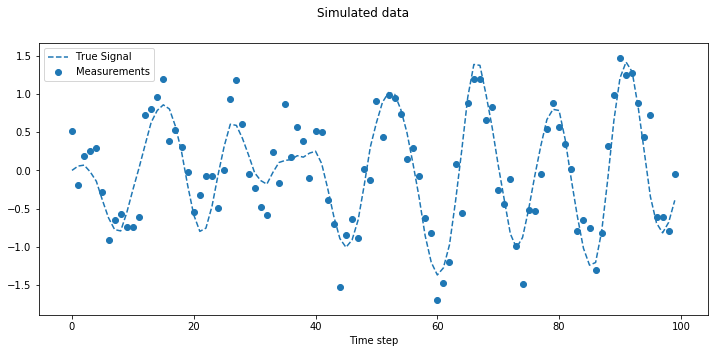

In [10]:
plot_state(observations, true_states, T)

## Initial Guess

In [11]:
initial_state = np.array([0, 1])
initial_covariance = np.eye(2)

## Baseline solution

In [12]:
def baseline_update_method(x, cov, obs):
    """ A baseline method that registers the measurement as the first component of the state, 
    and the time difference as the second component: this is a rough approximation of the time derivative.
    It does not change the covariance
    """
    return np.array([obs, obs - x[0]]), cov

In [13]:
baseline_states, _ = filter_routine(initial_state, initial_covariance, baseline_update_method, observations)

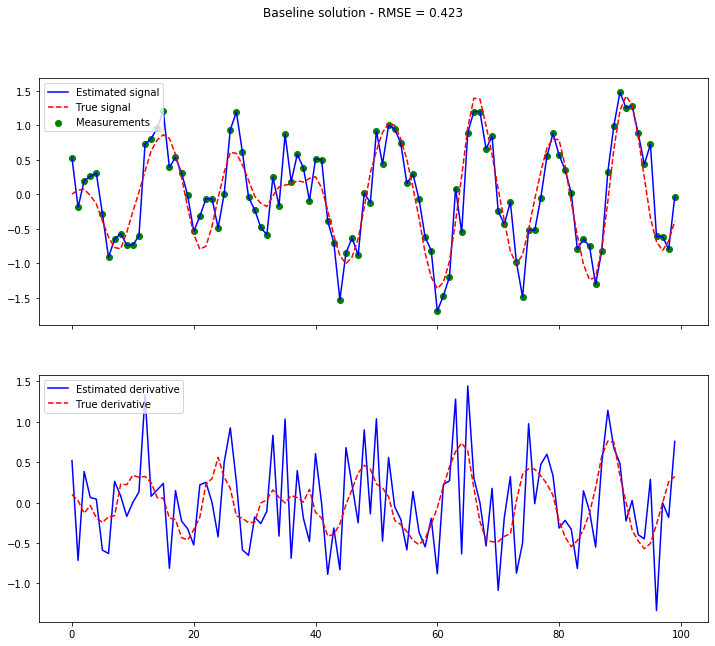

In [14]:
plot_results(baseline_states, true_states, observations, "Baseline solution", None)

## Kalman Filter

In [15]:
def kf_update(x, cov, obs):
    """ Implements the kalman equations , Bayesian Filtering and Smoothing", Ch.4.3
    Uses the global variables A, Q, C, r
    """
    # You should replace the below equations
    new_x = x
    new_cov = cov
    return new_x, new_cov

In [16]:
kalman_states, kalman_covariances = filter_routine(initial_state, initial_covariance, kf_update, observations)

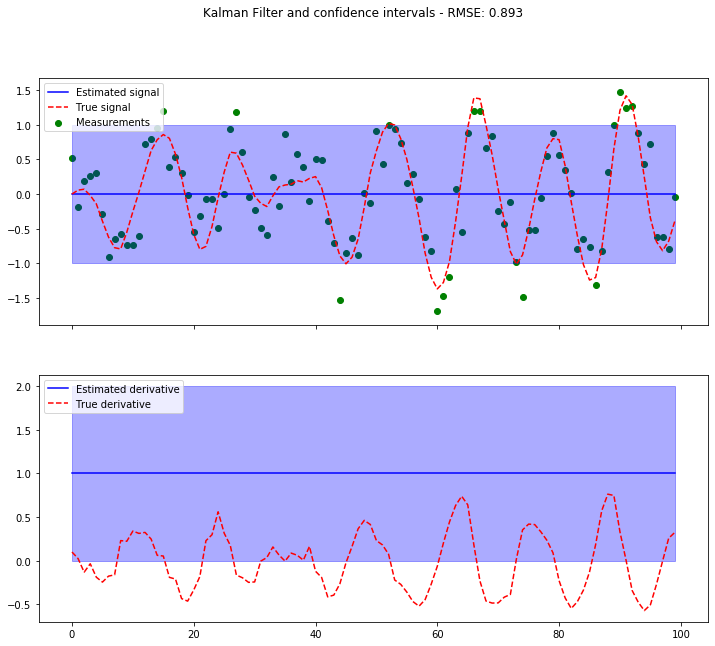

In [17]:
plot_results(kalman_states, true_states, observations, "Kalman Filter", kalman_covariances)

## Steady State Kalman Filter

In [18]:
def steady_kf_update(x, cov, obs):
    """ Implements the kalman equations with steady state , Bayesian Filtering and Smoothing", Exercise 4.5
    Uses the global variables A, Q, C, r
    """
    # You should replace the below equations.
    # you should implement an helper function to compute the steady Kalman Gain.
    new_x = x
    new_cov = cov
    return new_x, new_cov

In [19]:
steady_kalman_states, steady_kalman_covariances = filter_routine(initial_state, initial_covariance, steady_kf_update, observations)

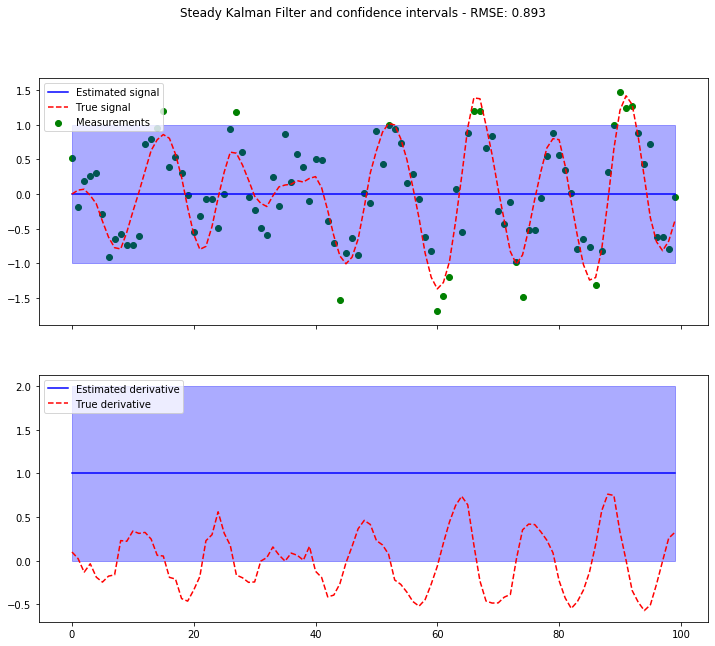

In [20]:
plot_results(steady_kalman_states, true_states, observations, "Steady Kalman Filter", steady_kalman_covariances)